# Image classification from the scratch

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/My\ Drive/Leaf_dataset.zip

Archive:  gdrive/My Drive/Leaf_dataset.zip
   creating: Leaf_dataset/Tomato_diseased/
  inflating: Leaf_dataset/Tomato_diseased/00639d29-2d1a-4fcf-9bd3-a2b3109c74c4___UF.GRC_BS_Lab Leaf 1054.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/01375198-62af-4c40-bddf-f3c11107200b___GCREC_Bact.Sp 5914.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/022e8a4a-9297-4de3-88a5-ee7aa46dd526___UF.GRC_BS_Lab Leaf 8682.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/03c8e0d0-6c57-4207-ad44-4d017c3e7943___GCREC_Bact.Sp 6325.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/04210e47-ad95-4648-8f1e-dc183581157c___UF.GRC_BS_Lab Leaf 0320.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/045e9a8d-bed0-4700-8d27-7f8d0735223e___GCREC_Bact.Sp 3848.jpeg  
  inflating: Leaf_dataset/Tomato_diseased/0493c0e5-27e3-41d6-81f0-7830cef39080___UF.GRC_BS_Lab Leaf 8615.jpeg  
  inflating: Leaf_dataset/Tomato_disea

In [ ]:
!ls Leaf_dataset

Tomato_diseased  Tomato_healthy


In [ ]:
import os

num_skipped = 0
for folder_name in ("Tomato_diseased", "Tomato_healthy"):
    folder_path = os.path.join("Leaf_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Leaf_dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 30 files belonging to 2 classes.
Using 24 files for training.
Using 6 files for validation.


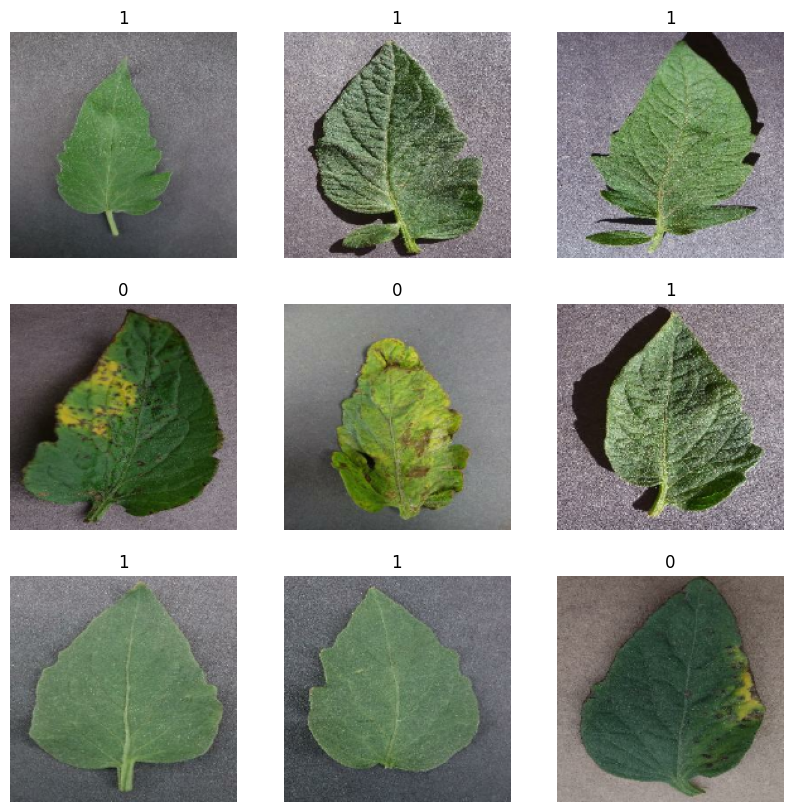

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

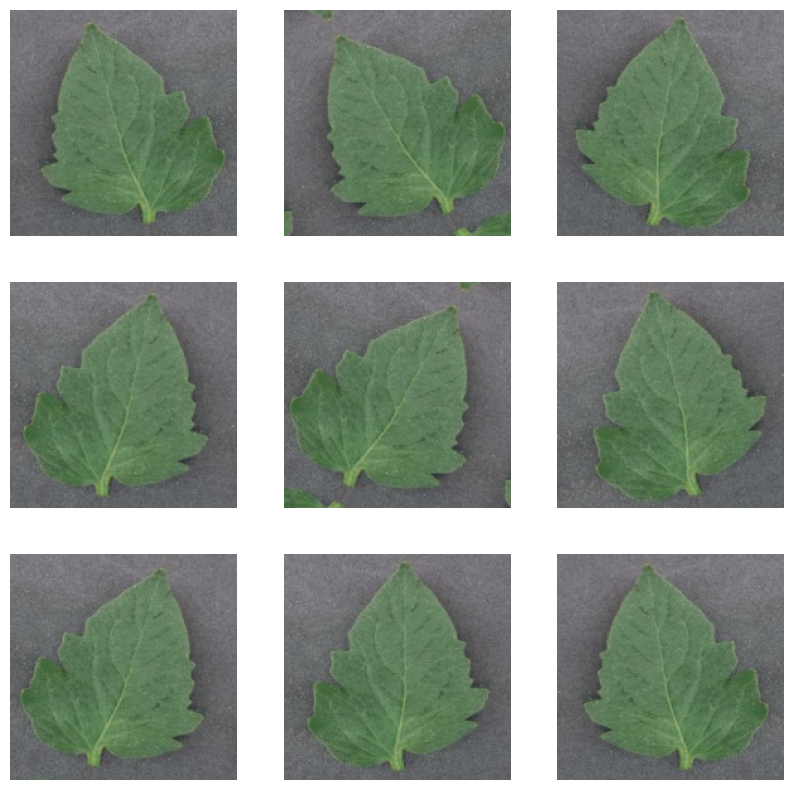

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

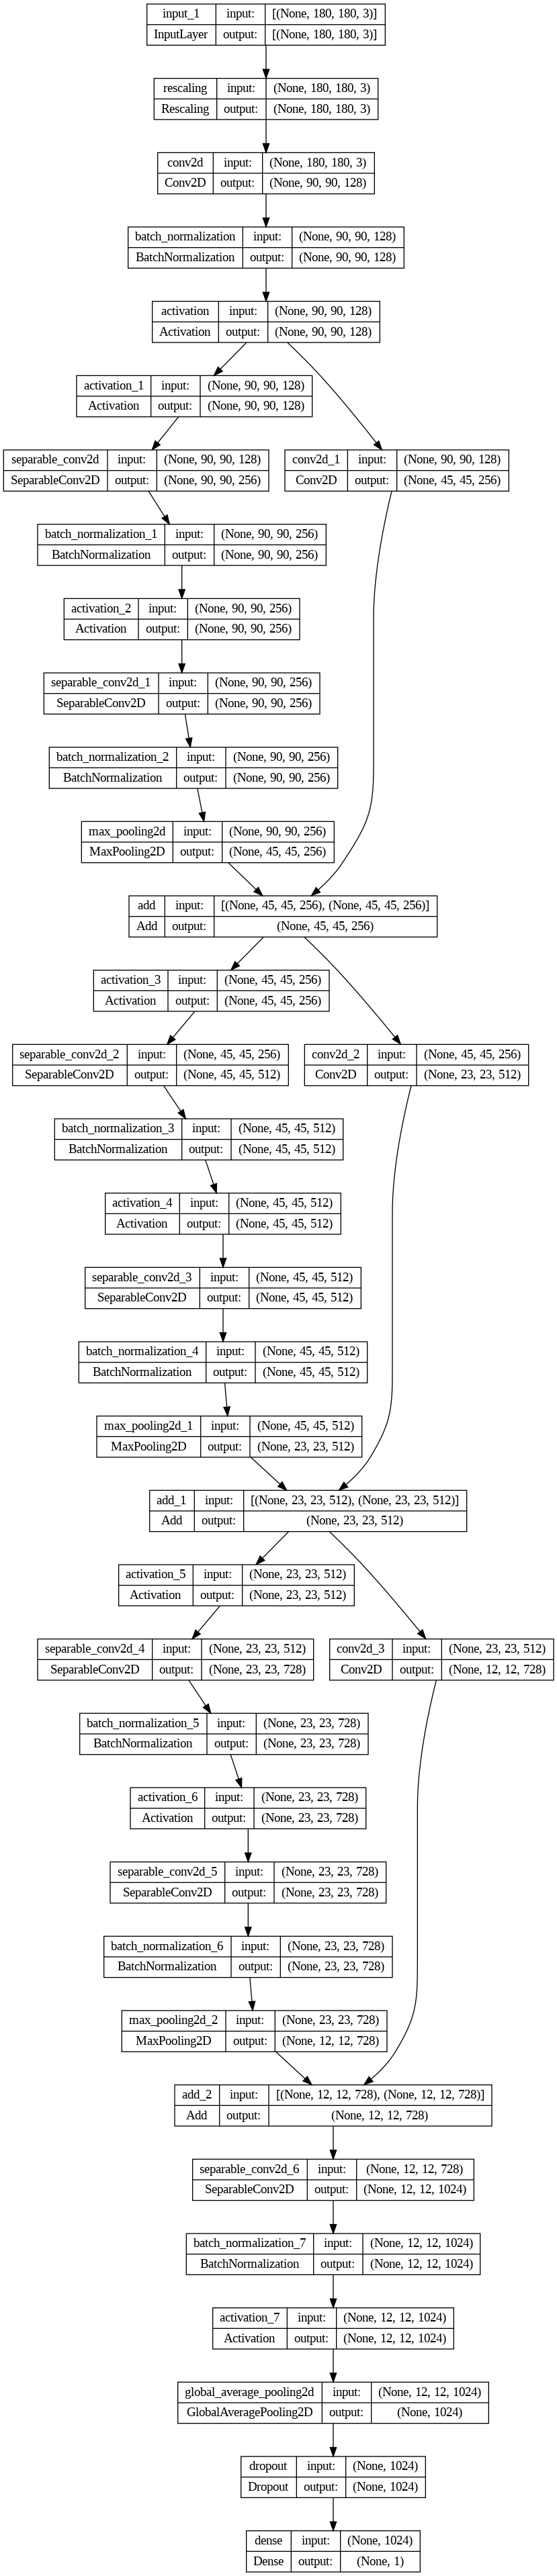

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.6994 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 1s 582ms/step - loss: 0.2631 - accuracy: 0.8750 - val_loss: 0.6955 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 1s 550ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 542ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 1s 543ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 1s 694ms/step - loss: 0.0512 - accuracy: 0.9583 - val_loss: 0.6944 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 1s 683ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.6971 - val_accuracy: 0.3333
Epoch 8/10
1/1 [=======

In [ ]:
img = keras.preprocessing.image.load_img(
    "Leaf_dataset/Tomato_diseased/07f5c629-92da-49ad-b132-6268199882f8___GCREC_Bact.Sp 3362.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% Diseased and {100 * score:.2f}% Healthy.")



1/1 [==============================] - 0s 19ms/step
This image is 52.01% Diseased and 47.99% Healthy.


NameError: ignored